**Wesleyan University ASTR 210**

# Homework 5

In this homework, we will work with Gaia data to examine the properties of stars in different regions of the Galaxy.

In [6]:
from matplotlib.colors import LogNorm

## Import statement

**(3 points)** Import numpy, matplotlib.pyplot, and astroquery.gaia as we have done before.

In [3]:
# YOUR CODE HERE

import numpy as np
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia

## Generating the galaxy map

The code below repeats the Gaia database query and generates the map from Tutorial 8.

In [4]:
query200000 = """SELECT 
TOP 200000
source_id, ra, dec, parallax
FROM gaiadr3.gaia_source
WHERE parallax > 0.1
AND parallax < 0.2
AND bp_rp IS NOT NULL
"""
job200000 = Gaia.launch_job_async(query200000)
results200000 = job200000.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


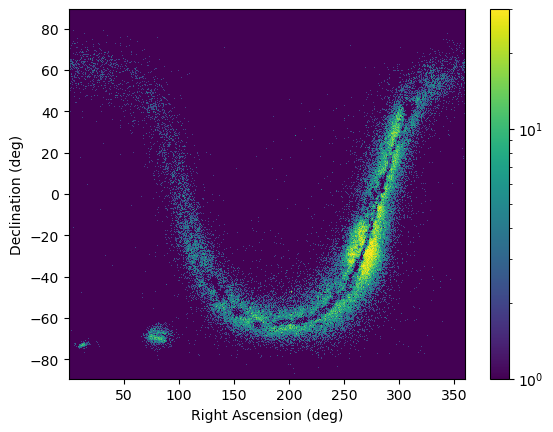

In [7]:
fig, ax = plt.subplots()
plt.hist2d(results200000['ra'], results200000['dec'], bins=500, norm=LogNorm(vmin=1,vmax=3e1, clip=True))
ax.set_xlabel('Right Ascension (deg)')
ax.set_ylabel('Declination (deg)')
plt.colorbar()

## Select regions in the Galaxy disk and bulge (30 points)

Just as we did with the Large Magellanic Cloud, we will use the CIRCLE selection to construct a new query to pick stars from specific regions on the sky corresponding to the galactic disk and the galactic bulge.

**(5 points)** Select your "disk" and "bulge" coordinates.  Change the values of ra_bulge, dec_bulge, ra_disk, and dec_disk until the red point (for the bulge) lies in the dense yellow region above or below the galactic center, and the cyan point (for the disk) lies somewhere along the galactic plane well outside the bulge.  

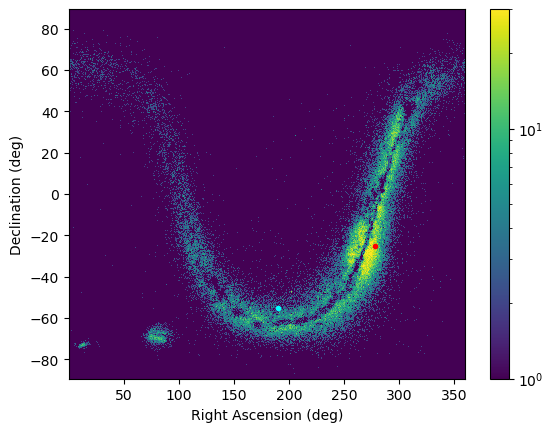

In [10]:
fig, ax = plt.subplots()
plt.hist2d(results200000['ra'], results200000['dec'], bins=500, norm=LogNorm(vmin=1,vmax=3e1, clip=True))
ax.set_xlabel('Right Ascension (deg)')
ax.set_ylabel('Declination (deg)')
plt.colorbar()

ra_bulge =278  # PICK NEW VALUE
dec_bulge = -25  # PICK NEW VALUE

ra_disk = 190  # PICK NEW VALUE
dec_disk = -55  # PICK NEW VALUE

plt.plot([ra_bulge], [dec_bulge], 'o', ms=3, color='red')
plt.plot([ra_disk], [dec_disk], 'o', ms=3, color='cyan')

**(10 points)** Create a new query (based on the one above) called bulge_query which:
- Adds a condition that the star must lie within a radius of 1 degree from the coordinates you chose for the bulge,
- Selects 400,000 stars, and 
- Additionally requests the columns for BP-RP color, G-band magnitude, radial velocity, and proper motion

In [11]:
bulge_query = f"""SELECT
TOP 400000
source_id, ra, dec, parallax, bp_rp, phot_g_mean_mag,radial_velocity, pmra, pmdec
FROM gaiadr3.gaia_source
WHERE CONTAINS (POINT('ICRS', ra, dec), CIRCLE('ICRS', {ra_bulge} , {dec_bulge}, 1)) = 1
AND parallax > 0.1
AND parallax < 0.2
AND bp_rp IS NOT NULL
"""# YOUR CODE HERE

**(5 points)** Launch an asynchronous job to submit your query, and save the results to a variable named bulgestars.  (Hint: if you want to do a sanity check first to make sure things are working ok, reduce the number of stars and do a test query before launching the 400,000-star query.)

In [12]:
job_bulgestars= Gaia.launch_job_async(bulge_query)
bulgestars = job_bulgestars.get_results()# YOUR CODE HERE

INFO: Query finished. [astroquery.utils.tap.core]


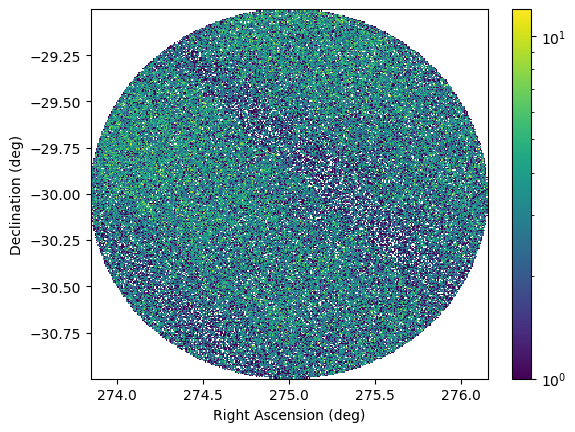

In [ ]:
fig, ax = plt.subplots()
plt.hist2d(bulgestars['ra'], bulgestars['dec'], bins=300, norm=LogNorm())
ax.set_xlabel('Right Ascension (deg)')
ax.set_ylabel('Declination (deg)')
plt.colorbar()

**(10 points)** Now repeat the process for the coordinates you chose for the disk: query the stars in an area within 1 degree, and save the results to a variable named diskstars.

In [13]:
disk_query = f"""SELECT
TOP 400000
source_id, ra, dec, parallax, bp_rp, phot_g_mean_mag,radial_velocity, pmra, pmdec
FROM gaiadr3.gaia_source
WHERE CONTAINS (POINT('ICRS', ra, dec), CIRCLE('ICRS', {ra_disk}, {dec_disk}, 1)) = 1
AND parallax > 0.1
AND parallax < 0.2
AND bp_rp IS NOT NULL
"""# YOUR CODE HERE
job_diskstars = Gaia.launch_job_async(disk_query)
diskstars = job_diskstars.get_results()


INFO: Query finished. [astroquery.utils.tap.core]


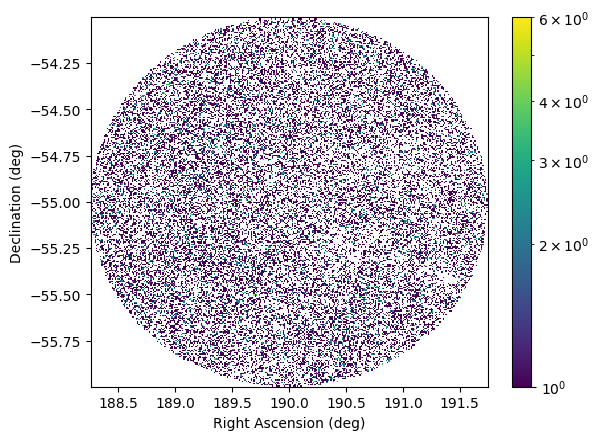

In [14]:
fig, ax = plt.subplots()
plt.hist2d(diskstars['ra'], diskstars['dec'], bins=300, norm=LogNorm())
ax.set_xlabel('Right Ascension (deg)')
ax.set_ylabel('Declination (deg)')
plt.colorbar()

## Calculate fraction of evolved stars in each sample (36 points)

First, let's take a look at the HR diagram for the disk sample.

**(10 points)** Plot BP-RP color (on the x-axis) against G-band magnitude (on the y-axis) using the disk DataFrame.  You can copy the *plt.hist2D()* example from above as a starting point.  You should:
- Label your axes appropriately
- Add a keyword argument *range=[[-1,4], [10,22]]* to the *hist2d()* call which will set the bounds of the plot
- Use *ax.set_ylim()* to flip the y-axis upside down
- Call *plt.title("Disk Stars")* to give the figure an appropriate heading

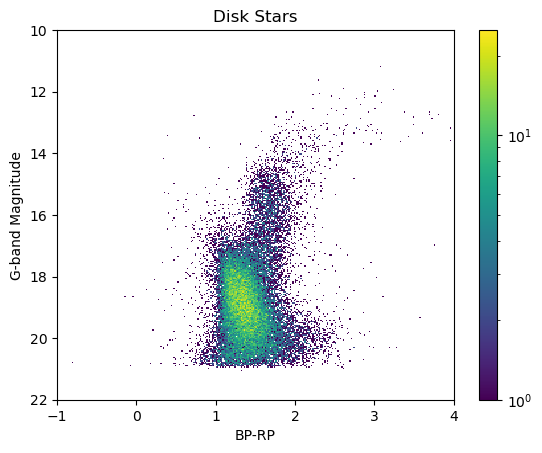

In [16]:
fig, ax = plt.subplots()
plt.hist2d(diskstars['bp_rp'], diskstars['phot_g_mean_mag'], bins=300, norm=LogNorm(),
           range=[[-1, 4], [10, 22]])
ax.set_xlabel('BP-RP')
ax.set_ylabel('G-band Magnitude')
ax.set_ylim(22, 10)
plt.title("Disk Stars")
plt.colorbar()


You should be able to see two distinct clouds of points going diagonally across the plot.  We are looking here at the top of the HR diagram ([full Gaia diagram here](https://sci.esa.int/web/gaia/-/60198-gaia-hertzsprung-russell-diagram)).  Because the values of parallax that we selected are pretty small, these stars are quite distant and so we are magnitude-limited just as we were with the bright star catalog earlier.  These two clouds represent the top of the main sequence of stars (on the bottom), and the evolved giant stars (on the top).

As we did with the SDSS galaxy sample in the last homework, let's define a line which will separate these two categories.

**(6 points)** Make another version of the plot above with a line separating the two categories of stars.  Below I have started you off by defining a set of x-coordinates for the line, a slope, and an intercept.  Create a corresponding set of y-coordinates, plot the line on top of the data, and mess with the values of the slope and intercept until you feel you have separated the clouds as cleanly as possible.

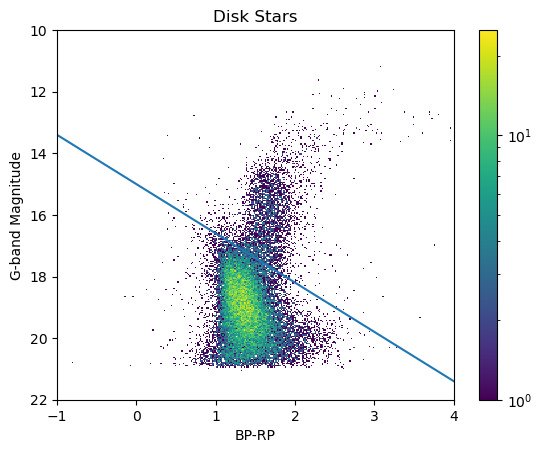

In [24]:
fig, ax = plt.subplots()
plt.hist2d(diskstars['bp_rp'], diskstars['phot_g_mean_mag'], bins=300, norm=LogNorm(),
           range=[[-1, 4], [10, 22]])
ax.set_xlabel('BP-RP')
ax.set_ylabel('G-band Magnitude')
ax.set_ylim(22, 10)
plt.title("Disk Stars")
plt.colorbar()# YOUR CODE HERE - copy plot from block above

x_color = np.linspace(-2,4,100)
slope = 1.5# MODIFY THIS VALUE
intercept = 15# MODIFY THIS VALUE
# YOUR CODE HERE - Define a y-value and plot the line

# YOUR CODE HERE - Define a y-value and plot the line
y = slope*x_color + intercept
plt.plot(x_color, y)

**(4 points)** Now that we have defined that dividing line, construct a Boolean array that is True for stars above the line and False for stars below it.  (Hint: it is a little confusing whether to use < or >, because the y-axis is flipped upside down.  Check your work by seeing whether there are more Trues or Falses in your Series and comparing that to the plot above.)

In [26]:
# Define the line equation
x_color = diskstars['bp_rp']
y_line = slope * x_color + intercept

# Construct the Boolean array
evolved_disk = diskstars['phot_g_mean_mag'] < y_line  # True for stars above the line

# Check the number of True and False values
print(f"Number of evolved stars (above line): {evolved_disk.sum()}")
print(f"Number of unevolved stars (below line): {(~evolved_disk).sum()}")

# YOUR CODE HERE

Number of evolved stars (above line): 4225
Number of unevolved stars (below line): 28079


**(10 points)** Repeat all of the steps above for the bulge sample: plot the HR diagram, find the line that separates the two clouds (it does not have to be exactly the same line), and use that line to define another Boolean array for evolved stars in the bulge sample.

Number of evolved stars (above line): 45136
Number of unevolved stars (below line): 113948


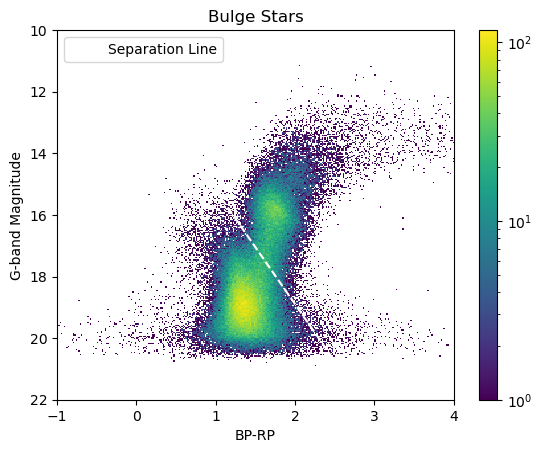

In [32]:
# YOUR CODE HERE
fig, ax = plt.subplots()
plt.hist2d(
    bulgestars['bp_rp'], 
    bulgestars['phot_g_mean_mag'], 
    bins=300, 
    norm=LogNorm(), 
    range=[[-1, 4], [10, 22]]
)
ax.set_xlabel('BP-RP')
ax.set_ylabel('G-band Magnitude')
ax.set_ylim(22, 10)  # Flip the y-axis
plt.title("Bulge Stars")
plt.colorbar()
x_color = np.linspace(-2, 4, 100)
slope_bulge = 3.7  # Adjust for the bulge
intercept_bulge = 11.5  # Adjust for the bulge
y_line_bulge = slope_bulge * x_color + intercept_bulge

# Plot the line over the HR diagram
plt.plot(x_color, y_line_bulge, color='white', linestyle='--', label='Separation Line')
plt.legend(loc="upper left")  
# Boolean array for evolved stars in the bulge
evolved_bulge = bulgestars['phot_g_mean_mag'] < (slope_bulge * bulgestars['bp_rp'] + intercept_bulge)

# Check the counts
print(f"Number of evolved stars (above line): {evolved_bulge.sum()}")
print(f"Number of unevolved stars (below line): {(~evolved_bulge).sum()}")




**(6 points)** Calculate and print the fraction of evolved stars in each set.  (Hint: this is equal to the number of entries that are "Evolved" divided by the total number of entries.)  

Does the result make sense to you based on what you see in the plots?  Does it make sense to you based on what you know about the ages of stars in the disk relative to the bulge?  (As a reminder: the disk is disproportionately composed of young stars, which have not yet evolved off the main sequence, while the bulge is disproportionately composed of old stars.)

In [33]:
# Disk
fraction_evolved_disk = evolved_disk.sum() / len(evolved_disk)

# Bulge
fraction_evolved_bulge = evolved_bulge.sum() / len(evolved_bulge)

print(f"Fraction of evolved stars in the disk: {fraction_evolved_disk:.2f}")
print(f"Fraction of evolved stars in the bulge: {fraction_evolved_bulge:.2f}")
# YOUR CODE HERE

Fraction of evolved stars in the disk: 0.13
Fraction of evolved stars in the bulge: 0.28


## Calculate kinematic statistics (29 points)

Let's take a look at the *dynamical* properties of the stars in the disk and the bulge.  We have two measurements of the stars' motion:
- Proper motion ('pm', milliarcseconds/yr): The movement of the star across the plane of the sky
- Radial velocity ('radial_velocity', km/s): The speed at which the star is approaching or receding from us

In addition to having different types of stellar populations, the disk and bulge also have different dynamics.  First we'll look at the proper motions.  Most stars in the Gaia catalog have a measured proper motion, because that's what Gaia was designed to do!

**(6 points)** Print out the mean and standard deviation of the proper motion of each group of stars.  (Yours will be slightly different from mine because you placed a different dot, that's ok!)

In [37]:
pm_disk = np.sqrt(diskstars['pmra']**2 + diskstars['pmdec']**2)
pm_bulge = np.sqrt(bulgestars['pmra']**2 + bulgestars['pmdec']**2)

print(f"Disk Proper Motion: Mean={pm_disk.mean():.2f}, StdDev={pm_disk.std():.2f}")
print(f"Bulge Proper Motion: Mean={pm_bulge.mean():.2f}, StdDev={pm_bulge.std():.2f}")


Disk Proper Motion: Mean=6.96, StdDev=2.51
Bulge Proper Motion: Mean=5.90, StdDev=2.49


Take a look at the result and imagine what the underlying distributions might look like.  (Remember that the *mean* sets the center while the *standard deviation* sets the spread.)

**(10 points)** Plot the full distribution of proper motions in the two samples as probability density functions.  Do they look the way you imagined?

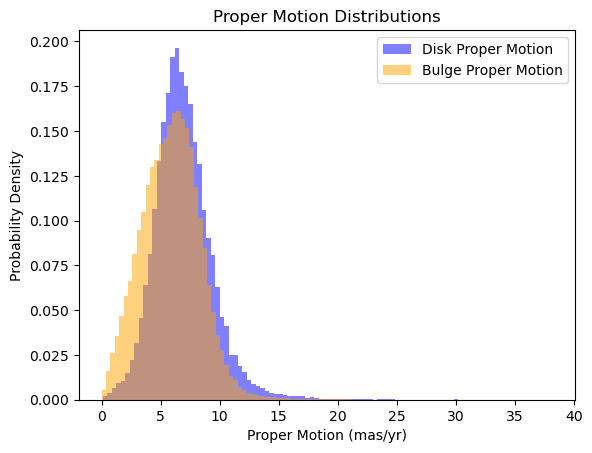

In [38]:
fig, ax = plt.subplots()

# Plot disk proper motion distribution
ax.hist(pm_disk, bins=100, density=True, alpha=0.5, label="Disk Proper Motion", color='blue')

# Plot bulge proper motion distribution
ax.hist(pm_bulge, bins=100, density=True, alpha=0.5, label="Bulge Proper Motion", color='orange')

# Add labels and legend
ax.set_xlabel("Proper Motion (mas/yr)")
ax.set_ylabel("Probability Density")
ax.set_title("Proper Motion Distributions")
ax.legend()
plt.show()
# YOUR CODE HERE

**(13 points)** Repeat the same exercise for the radial velocities in the two samples: print out the mean and standard deviation, then plot the full distributions.

Disk Radial Velocity: Mean = 5.72 km/s, StdDev = 52.47 km/s


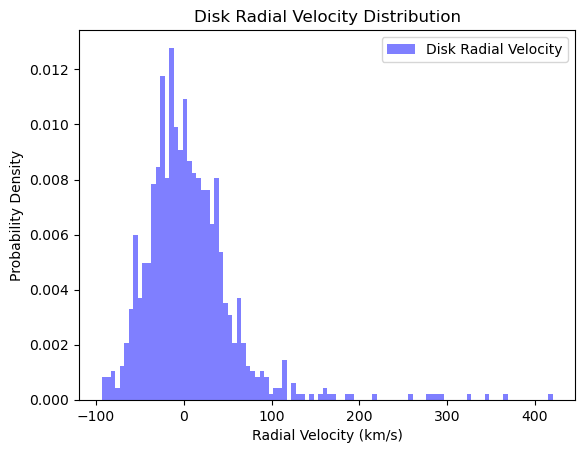

In [41]:
# Filter out null radial velocities for the disk
rv_disk = diskstars['radial_velocity'][~np.isnan(diskstars['radial_velocity'])]

# Calculate statistics for the disk
mean_rv_disk = rv_disk.mean()
std_rv_disk = rv_disk.std()

# Print the results for the disk
print(f"Disk Radial Velocity: Mean = {mean_rv_disk:.2f} km/s, StdDev = {std_rv_disk:.2f} km/s")

# Plot radial velocity distribution for the disk
fig, ax = plt.subplots()
ax.hist(rv_disk, bins=100, density=True, alpha=0.5, label="Disk Radial Velocity", color='blue')
ax.set_xlabel("Radial Velocity (km/s)")
ax.set_ylabel("Probability Density")
ax.set_title("Disk Radial Velocity Distribution")
ax.legend()
plt.show()



Bulge Radial Velocity: Mean = 12.76 km/s, StdDev = 80.63 km/s


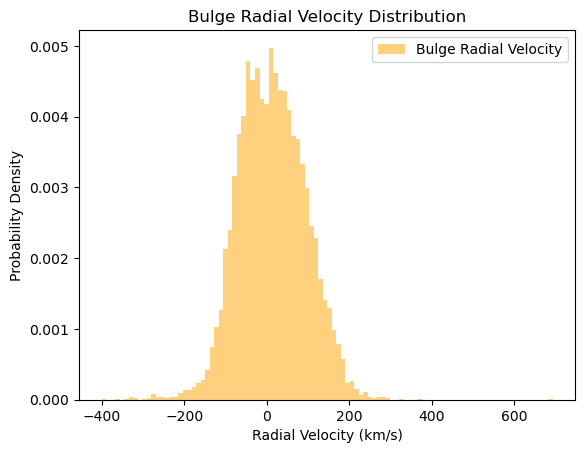

In [42]:
# YOUR CODE HERE
# Filter out null radial velocities for the bulge
rv_bulge = bulgestars['radial_velocity'][~np.isnan(bulgestars['radial_velocity'])]

# Calculate statistics for the bulge
mean_rv_bulge = rv_bulge.mean()
std_rv_bulge = rv_bulge.std()

# Print the results for the bulge
print(f"Bulge Radial Velocity: Mean = {mean_rv_bulge:.2f} km/s, StdDev = {std_rv_bulge:.2f} km/s")

# Plot radial velocity distribution for the bulge
fig, ax = plt.subplots()
ax.hist(rv_bulge, bins=100, density=True, alpha=0.5, label="Bulge Radial Velocity", color='orange')
ax.set_xlabel("Radial Velocity (km/s)")
ax.set_ylabel("Probability Density")
ax.set_title("Bulge Radial Velocity Distribution")
ax.legend()
plt.show()


Depending on what coordinates you chose for the disk sample, the stars in the disk are likely moving faster than the stars in the bulge.  Despite the bulge stars' slightly slower average velocities, the *standard deviation* of their velocities is probably higher.  That means that there's a wider distribution of velocities.  The relatively narrow distribution of velocities in the disk is referred to as being *dynamically cold* - they are moving fast, but they're moving *together*, in coherent rotation around the galactic center.  The stars in the bulge are *dynamically hot* - their motion is not coherent, the stars are moving in more random directions.

**(2 points)** Last one: from 1-5, how difficult was this assignment?  (Were there any parts that were especially fun, frustrating, or unclear?)

*[YOUR RESPONSE HERE]*

In [ ]:
'''5-The kinematics section was the hardest
'''